# Data Collection

In [1]:
# The code was removed by Watson Studio for sharing.

#### Install the necessary package.

In [2]:
!pip install watson-developer-cloud==1.5
!pip install --user ipython-sql 
!pip install --user ibm_db 
!pip install --user ibm_db_sa
!pip install matplotlib

#### Import the necessary libraries

In [3]:
import requests
import urllib.request
import time
import datetime
import csv
import re
import unicodedata
import ibm_db
from bs4 import BeautifulSoup
import pandas as pd 
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

#### I've pre-defined some redundant functions here so as to reduce the complexity and size of the code

In [4]:
#function to check if we have access to the website
def access_to_server(a):
    if(access.status_code == 200):
        print("Access to PlaneCrashInfo.com: Granted")
    else:
        print("Access to PlaneCrashInfo.com: Denied")
        
#function to pause for a little so that the website server does not flag us as a spammer
def take_a_break():
    time.sleep(0.1)      #we pause for 3 seconds

#function to access the website
def access_website(url):
    access = None
    access = requests.get(url,timeout=10)
    return access   

def get_data(search_string, regex):
    pattern = re.compile(regex)
    matches = pattern.finditer(search_string)

    for match in matches:
        match = match.span()

    span = search_string[match[0]:match[1]]
    return span

#predefine a dataframe to store out clean data
#headers = ['Date','Time','Location','Operator','Flight#','Route','AC Type','Registration','cn/ln','Total Aboard','Passengers Aboard','Crew Aboard','Total Fatalities','Passenger Fatalities','Crew Fatalities','Ground','Summary']
df = pd.DataFrame(columns=['Date','Time','Location','Operator','Flight_Number','Route','AC Type','Registration','cn/ln','Total_Aboard','Passengers_Aboard','Crew_Aboard','Total_Fatalities','Passenger_Fatalities','Crew_Fatalities','Ground','Summary'])
clean_data= df
clean_data

,Date,Time,Location,Operator,Flight_Number,Route,AC Type,Registration,cn/ln,Total_Aboard,Passengers_Aboard,Crew_Aboard,Total_Fatalities,Passenger_Fatalities,Crew_Fatalities,Ground,Summary


#### Next, we set the url to the Plane Crash Info website and access the site with our requests library. We also set the base url to create a dictionary with years as the key.

In [5]:
base_url = "http://www.planecrashinfo.com"
access = requests.get('http://www.planecrashinfo.com/database.htm')
access_to_server(access)
source = BeautifulSoup(access.text, 'html.parser')

Access to PlaneCrashInfo.com: Granted


 #### Here we build a dictionary with the url stores as the value and the year as the key

In [6]:
a_tags = source.find_all("a")
years = {a.text.strip(): {"url": base_url + a["href"] if a["href"][0] == "/" else base_url + "/" + a["href"]} for a in a_tags if a.text.strip().isdigit()}

#### Here we pause for a little to avoid getting flagged as a spammer.

In [7]:
take_a_break()

#### Now we start collecting the unstructured data

In [8]:
done = 0
for year, database in years.items():       #first we loop for each year from 1920 until 2019
    print(year)
    #if year == '1921':
    #    break
    take_a_break()
    response_year = access_website(database["url"])
    access_to_server(response_year)
    parser_year = BeautifulSoup(response_year.content, 'html.parser')
    a_tags2 = parser_year.find_all("a")
    a_tags2 = [a for a in a_tags2 if "Return to Home" not in a.text]
    for a in a_tags2:
            # request to crash detail page
            response_crash = access_website(base_url + "/" + year + a["href"] if a["href"][0] == "/" else base_url + "/" + year + "/" + a["href"])
            if (response_crash.status_code == 404):
                continue
            parser_crash = BeautifulSoup(response_crash.content, 'html.parser')
            tr_tags = parser_crash.find_all("tr")
            tr_tags = tr_tags[1:]

            database = [tr.find_all("td")[1].text.strip() for tr in tr_tags]  
            x = database
            #Splitting the data in the aboard row
            aboard_row = x[9]
            #remove \xa0 from the string
            aboard_row = unicodedata.normalize("NFKD", aboard_row)
            #remove duplicate spaces from the string
            aboard_row = re.sub(' +', ' ',aboard_row)
            #split the string to extract the data easily
            split_aboard_row = aboard_row.split(" ")
            #find the total number of people aboard
            total_aboard = split_aboard_row[0]
            #total_aboard = int(total_aboard)
            #find the total number of passengers aboard
            passengers_aboard = split_aboard_row[1]
            passengers_aboard = passengers_aboard[-1]
            #find the total number of crew members aboard
            crew_aboard = split_aboard_row[2]
            crew_aboard = crew_aboard[-2]

            #Splitting the data in the fatalities row
            fatalities_row = x[10]
            #remove \xa0 from the string
            fatalities_row = unicodedata.normalize("NFKD", fatalities_row)
            #remove duplicate spaces from the string
            fatalities_row = re.sub(' +', ' ',fatalities_row)
            #split the string to extract the data easily
            split_fatalities_row = fatalities_row.split(" ")
            #find the total number of fatalities
            total_fatalities = split_fatalities_row[0]
            #find the total number of passenger fatalities
            passenger_fatalities = split_fatalities_row[1]
            passenger_fatalities = passenger_fatalities[-1]
            #find the total number of crew fatalities
            crew_fatalities = split_fatalities_row[2]
            crew_fatalities = crew_fatalities[-2]

            #save data for reorganization
            ground = x[11]
            summary = x[12]
            x[9] = total_aboard
            x[10] = passengers_aboard
            x[11] = crew_aboard
            x[12] = total_fatalities

            u= [passenger_fatalities, crew_fatalities, ground, summary]
            x.extend(u)
            #appending the values to the previously generated dataframe
            #df1 = pd.DataFrame(x) 
            #q= df1.T
            #clean_data = clean_data.append(q, ignore_index=True, sort=False)
            #df = pd.DataFrame(columns=['Date','Time','Location','Operator','Flight#','Route','AC Type','Registration','cn/ln','Total Aboard','Passengers Aboard','Crew Aboard','Total Fatalities','Passenger Fatalities','Crew Fatalities','Ground','Summary'])
            clean_data = clean_data.append({'Date':x[0],'Time':x[1],'Location':x[2],'Operator':x[3],'Flight_Number':x[4],'Route':x[5],'AC Type':x[6],'Registration':x[7],'cn/ln':x[8],'Total_Aboard':x[9],'Passengers_Aboard':x[10],'Crew_Aboard':x[11],'Total_Fatalities':x[12],'Passenger_Fatalities':x[13],'Crew_Fatalities':x[14],'Ground':x[15],'Summary':x[16]}, ignore_index=True)

1920
Access to PlaneCrashInfo.com: Granted
1921
Access to PlaneCrashInfo.com: Granted
1922
Access to PlaneCrashInfo.com: Granted
1923
Access to PlaneCrashInfo.com: Granted
1924
Access to PlaneCrashInfo.com: Granted
1925
Access to PlaneCrashInfo.com: Granted
1926
Access to PlaneCrashInfo.com: Granted
1927
Access to PlaneCrashInfo.com: Granted
1928
Access to PlaneCrashInfo.com: Granted
1929
Access to PlaneCrashInfo.com: Granted
1930
Access to PlaneCrashInfo.com: Granted
1931
Access to PlaneCrashInfo.com: Granted
1932
Access to PlaneCrashInfo.com: Granted
1933
Access to PlaneCrashInfo.com: Granted
1934
Access to PlaneCrashInfo.com: Granted
1935
Access to PlaneCrashInfo.com: Granted
1936
Access to PlaneCrashInfo.com: Granted
1937
Access to PlaneCrashInfo.com: Granted
1938
Access to PlaneCrashInfo.com: Granted
1939
Access to PlaneCrashInfo.com: Granted
1940
Access to PlaneCrashInfo.com: Granted
1941
Access to PlaneCrashInfo.com: Granted
1942
Access to PlaneCrashInfo.com: Granted
1943
Access

In [19]:
data_copy = clean_data
data_copy
#total_aboard

,Date,Time,Location,Operator,Flight_Number,Route,AC Type,Registration,cn/ln,Total_Aboard,Passengers_Aboard,Crew_Aboard,Total_Fatalities,Passenger_Fatalities,Crew_Fatalities,Ground,Summary
0,"September 17, 1908",1718,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly..."
1,"September 07, 1909",?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...
2,"July 12, 1912",0630,"Atlantic City, New Jersey",Military - U.S. Navy,?,Test flight,Dirigible,?,?,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...
3,"August 06, 1913",?,"Victoria, British Columbia, Canada",Private,?,?,Curtiss seaplane,?,?,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...
4,"September 09, 1913",1830,Over the North Sea,Military - German Navy,?,?,Zeppelin L-1 (airship),?,?,20,?,?,14,?,?,0,The airship flew into a thunderstorm and encou...
5,"October 17, 1913",1030,"Near Johannisthal, Germany",Military - German Navy,?,?,Zeppelin L-2 (airship),?,?,30,?,?,30,?,?,0,Hydrogen gas which was being vented was sucked...
6,"March 05, 1915",0100,"Tienen, Belgium",Military - German Navy,?,?,Zeppelin L-8 (airship),?,?,41,?,?,21,?,?,0,Crashed into trees while attempting to land af...
7,"September 03, 1915",1520,"Off Cuxhaven, Germany",Military - German Navy,?,?,Zeppelin L-10 (airship),?,?,19,?,?,19,?,?,0,"Exploded and burned near Neuwerk Island, when..."
8,"July 28, 1916",?,"Near Jambol, Bulgeria",Military - German Army,?,?,Schutte-Lanz S-L-10 (airship),?,?,20,?,?,20,?,?,0,"Crashed near the Black Sea, cause unknown."
9,"September 24, 1916",0100,"Billericay, England",Military - German Navy,?,?,Zeppelin L-32 (airship),?,?,22,?,?,22,?,?,0,Shot down by British aircraft crashing in flames.


In [10]:
#Save the dataframe as a CSV to Object Storage
#Commented out after saving once. 
project.save_data(data=data_copy.to_csv(index=False),file_name='planecrashinfo_data1711.csv',overwrite=True)

{'file_name': 'planecrashinfo_data1711.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'crestview-donotdelete-pr-i9vprxww0objz7',
 'asset_id': '6859a3ce-b512-45f8-a851-8d5878697daf'}

#### Saving the dataframe as CSV file, I loaded it into IBM db2 database as backup and to allow future access. Below is just a test code to access that SQL databse table. This test code has been used again in the other Jupyter notebooks for the explolatory data analysis. 

In [11]:
#perform simplified database access using SQL "magic"
#%load_ext sql
# %sql ibm_db_sa://my-username:my-password@dashdb-txn-sbox-yp-dal09-03.services.dal.bluemix.net:50000/BLUDB
#the cell after this one is hidden because it contains senstive information that provides access to my IBM Cloud account. The code is similar to the line above except for the username and password.

In [12]:
# The code was removed by Watson Studio for sharing.

In [13]:
#%sql select * from PlaneCrashInfoDatabase

# Data Cleaning

In [24]:
#just another copy of data
crash_data = data_copy
#First I have replaced all the ? with NaN so that we can change the datatypes of the columns easily)
crash_data = crash_data.replace('?', np.NaN)
#crash_data = crash_data.dropna(subset=['Total_Fatalities'],how='any', inplace=True)
#project.save_data(data=data_copy.to_csv(index=False),file_name='planecrashinfo_wNaN.csv',overwrite=True)

{'file_name': 'planecrashinfo_wNaN.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'crestview-donotdelete-pr-i9vprxww0objz7',
 'asset_id': '753e9a98-e6b0-42aa-af4d-1b27c69150b1'}

In [42]:
crash_data

,Date,Time,Location,Operator,Flight_Number,Route,AC Type,Registration,cn/ln,Total_Aboard,Passengers_Aboard,Crew_Aboard,Total_Fatalities,Passenger_Fatalities,Crew_Fatalities,Ground,Summary
0,"September 17, 1908",1718,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly..."
1,"September 07, 1909",NaN,"Juvisy-sur-Orge, France",NaN,NaN,Air show,Wright Byplane,SC1,NaN,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...
2,"July 12, 1912",0630,"Atlantic City, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...
3,"August 06, 1913",NaN,"Victoria, British Columbia, Canada",Private,NaN,NaN,Curtiss seaplane,NaN,NaN,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...
4,"September 09, 1913",1830,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20,NaN,NaN,14,NaN,NaN,0,The airship flew into a thunderstorm and encou...
5,"October 17, 1913",1030,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30,NaN,NaN,30,NaN,NaN,0,Hydrogen gas which was being vented was sucked...
6,"March 05, 1915",0100,"Tienen, Belgium",Military - German Navy,NaN,NaN,Zeppelin L-8 (airship),NaN,NaN,41,NaN,NaN,21,NaN,NaN,0,Crashed into trees while attempting to land af...
7,"September 03, 1915",1520,"Off Cuxhaven, Germany",Military - German Navy,NaN,NaN,Zeppelin L-10 (airship),NaN,NaN,19,NaN,NaN,19,NaN,NaN,0,"Exploded and burned near Neuwerk Island, when..."
8,"July 28, 1916",NaN,"Near Jambol, Bulgeria",Military - German Army,NaN,NaN,Schutte-Lanz S-L-10 (airship),NaN,NaN,20,NaN,NaN,20,NaN,NaN,0,"Crashed near the Black Sea, cause unknown."
9,"September 24, 1916",0100,"Billericay, England",Military - German Navy,NaN,NaN,Zeppelin L-32 (airship),NaN,NaN,22,NaN,NaN,22,NaN,NaN,0,Shot down by British aircraft crashing in flames.


### Total_Fatalities vs Date

In [90]:
#I start with creating another copy of the dataframe called cr with just the two required columns
cr = crash_data.loc[:, ['Date','Total_Fatalities']]
#convert the 'Date' column to Datetime dtype
cr['Date'] =  pd.to_datetime(cr['Date'],format='%B %d, %Y')
#replace all the '?' values in both the columns with NaN
cr = cr[cr.Total_Fatalities != 'NaN']
#we now find out the number of rows that contain NaN values
cr.isna().sum()

Date                0
Total_Fatalities    8
dtype: int64

In [91]:
#from the solution above, the column 'Date' has 0 NaN rows and the column 'Total_Fatalities' has 8 NaN rows. 
#Out of the 4964 observations, 8 observations only constitute of 0.16% of the data. Therefore, I have omitted these NaN values from the Total_Fatalities vs Date table.
cr=cr.dropna(axis=0)
#we check for rows with NaN values again, just to confirm.
cr.isna().sum()

Date                0
Total_Fatalities    0
dtype: int64

In [92]:
#Now I convert the Total_Fatalities column to 'int32' dtype.
cr = cr.astype({'Total_Fatalities': 'int32'})

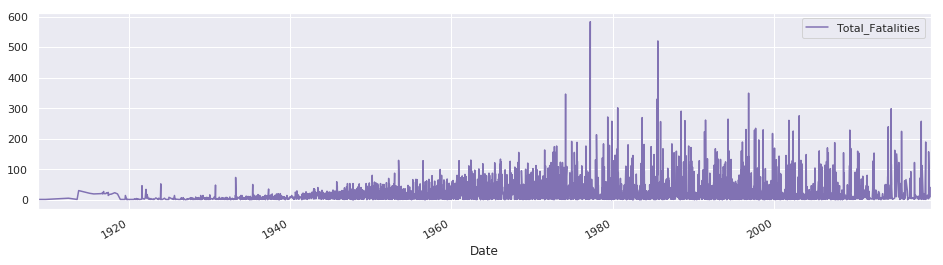

In [93]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
#sns.set(rc={'figure.figsize':(16, 4)})
#cr['Total_Fatalities'].plot(linewidth=0.5);
cr.plot(kind='line',x='Date',y='Total_Fatalities',color='m')

In [94]:
#now I have created another copy of cr because the above plot was ugly and I was looking for a visually appealing visualization.
cr2 = cr
cr2['year'] = pd.DatetimeIndex(cr2['Date']).year
cr2.describe()

,Total_Fatalities,year
count,4957.000000,4957.000000
mean,22.339923,1970.719790
std,35.032160,24.537513
min,0.000000,1908.000000
25%,4.000000,1951.000000
50%,11.000000,1970.000000
75%,25.000000,1991.000000
max,583.000000,2019.000000


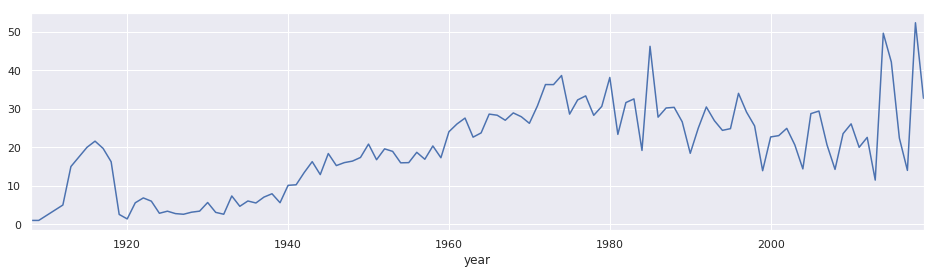

In [89]:
#The plot below groups the 'Total_Fatalities' by year and then plots it; thereby, showing a better trend of crashes.
cr2.groupby("year")['Total_Fatalities'].mean().plot(kind='line')